<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/UNetmodelcode_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')
!cd "drive/My Drive/PhD/IRLabeledDataset"

Mounted at /content/drive


In [7]:

# CreateImageDirPaths.py
import os

inputDir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored" # directory containing input colored images (converted from grayscale)
segmentationImageDir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized" # directory containing output segmentation images


def createImageDirPaths():

    if (not inputDir):
        print("The input dir is empty")
    if(not segmentationImageDir):
        print("The segmentation dir is empty")

    input_img_paths = sorted (
        [
            os.path.join(inputDir, fName)
            for fName in os.listdir(inputDir)
                if fName.endswith(".png")
        ]
    )

    target_img_paths = sorted (
        [
            os.path.join(segmentationImageDir, fName)
            for fName in os.listdir(segmentationImageDir)
                if fName.endswith(".png") and not fName.startswith(".")
        ]
    )

    print("Number of samples = {0}".format(len(input_img_paths)))
    print (input_img_paths)

    for input_path, segmentation_mask_path in zip(input_img_paths[:10], target_img_paths[:10]):
        print(input_path, "|", segmentation_mask_path)

    return input_img_paths, target_img_paths

In [8]:
# DataSequence.py
from tensorflow import keras
import numpy as np

from tensorflow.keras.preprocessing.image import load_img

class MarineImages(keras.utils.Sequence):
    """ Helper to iterate over data (as Numpy array) """

    def __init__(self, batchSize, imageSize, input_img_paths, target_img_paths):
        self.batchSize = batchSize
        self.imageSize = imageSize
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batchSize

    def __getitem__(self, idx):
        """ Returns tuple (input, segmentation mask) corresponding to batch #idx """

        i = idx * self.batchSize
        batch_input_img_paths = self.input_img_paths[i : i + self.batchSize]
        batch_target_img_paths = self.target_img_paths[i : i + self.batchSize]
        # use 3 & float32 as input image is RGB (converted from grayscale).  
        x = np.zeros((self.batchSize,) + self.imageSize + (3,), dtype="float32")
        #print("x size = {0}".format(x.shape))

        for index, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.imageSize)
            #print("index = {0}, path = {1}".format(index, path))
            #print("target size = {0}".format(self.imageSize))
            #print("img shape in PIL format = {0}".format(img.size))
            #print("shape of x[{0}] = {1}".format(index, x[index].shape))
            x[index] = img
 
        # use 1 & uint8 as labled image is also grayscale 
        y = np.zeros((self.batchSize,) + self.imageSize + (1,),dtype="uint8")
        for indexY, path in enumerate(batch_segmentation_img_paths):
            img = load_img(path, target_size=self.imageSize, color_mode="grayscale")
            y[indexY] = np.expand_dims(img,2) # this is needed because we are trying with RGB image 
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1. We don't need this as our labels(category id) start with 0

        return x, y
    

In [ ]:
''' this is not needed 
# Dockerfile
# step 1: xhost +local:docker
# docker run -u $(id -u):$(id -g) -it --rm -e DISPLAY=${DISPLAY} --gpus all -v $(pwd)/:/UNet:consistent -v /home/shailesh/Work/catkin_ws/src/simplepackage/src/IRLabeledDataset/:/IRLabeledDataset:consistent -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/home/xterm/.Xauthority --hostname $(hostname) -p 0.0.0.0:6006:6006 tensorflow/tensorflow:2.4.0-gpu bash 
# docker run -u $(id -u):$(id -g) -it --rm -e DISPLAY=${DISPLAY} --gpus all -v $(pwd)/:/UNet:consistent -v /home/shailesh/Work/catkin_ws/src/simplepackage/src/IRLabeledDataset/:/IRLabeledDataset:consistent -v /tmp/.X11-unix:/tmp/.X11-unix -v ${HOME}/.Xauthority:/home/xterm/.Xauthority --hostname $(hostname) -p 0.0.0.0:6006:6006 unet:1 bash 

FROM tensorflow/tensorflow:2.4.0-gpu
ENV DISPLAY=$DISPLAY
ENV CUDA_VISIBLE_DEVICES=0

RUN set -eu pipefail && \
    export DEBIAN_FRONTEND=noninteractive && \
    apt-get update && \
    apt-get -y upgrade && \
    pip install Image && \
    apt-get -y install python-scipy python-matplotlib && \
    apt-get clean && \
    rm -rf /var/lib/apt/lists/*

#docker build -t unet:1 .    
'''

In [9]:
#UNet_model.py
from tensorflow.keras import layers
import tensorflow as tf

def create_model(imageSize, numClasses):

    # use 3 as it's RGB
    inputs = tf.keras.Input(shape=imageSize + (3,))

    ## First half of network : Encoder : Downsampling inputs

    ## Entry block
    ## 2nd argument is kernel size
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same", kernel_initializer = 'he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x # Set aside the residual

    # Blocks 1, 2, 3 are identical except feature depth. filters are upsampling / downsampling slabs for unet
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same", kernel_initializer = 'he_normal')(previous_block_activation)
        x = tf.keras.layers.add([x, residual])

        previous_block_activation = x # Set aside the next residual

    # second half of the network : upsampling inputs
    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same", kernel_initializer = 'he_normal')(residual)
        x = tf.keras.layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual

    # add per pixel classification layer
    outputs = tf.keras.layers.Conv2D(numClasses, 3, activation="softmax", padding="same")(x)

    # define the model
    model = tf.keras.Model(inputs, outputs)
    return model









In [10]:
#main.py 
import os
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint
#from UNet_model import create_model 
#from CreateImageDirPaths import createImageDirPaths 
#from DataSequence import MarineImages 
import PIL

import random
from tensorflow import keras
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps



imageSize = (640, 512)
numClasses = 7
# sky:0, water:1, structure:2, Obstacle:3, living obstacle:4, background:5, self:6
batchSize = 5 # This may not be possible.
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

[input_img_paths, target_img_paths] = createImageDirPaths()

print("input img paths = {0}".format(input_img_paths))
print("Type of input_img_paths = {0}".format(type(input_img_paths)))



# Build model
model = create_model(imageSize, numClasses)
model.summary()



Number of samples = 62
['/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388082.940481_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388099.294270_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388115.497458_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388165.895730_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388188.478616_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388213.024487_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388233.503927_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized_colored/1603388257.753172_resized_color.png', '/content/drive/MyDrive/PhD/IRLabeledDat

In [ ]:
# now train the model 

# split image paths into a training and a validation set
validation_samples = 5
random.Random(5).shuffle(input_img_paths)
random.Random(5).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-validation_samples]
train_target_img_paths = target_img_paths[:-validation_samples]
validation_input_img_paths = input_img_paths[-validation_samples:]
validation_target_img_paths = target_img_paths[-validation_samples:]

# Instantiate data Sequences for each split
marineData_training = MarineImages(batchSize, imageSize, train_input_img_paths, train_target_img_paths)
marineData_validation = MarineImages(batchSize, imageSize, validation_input_img_paths, validation_target_img_paths)

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

# changing as loss was coming as NAN. this loss value gives NAN
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

from keras.optimizers import Adam
opt = Adam(learning_rate=0.001) #0.001 was the default, so try a smaller one
model.compile(optimizer=opt, loss='binary_crossentropy')

callback = [tf.keras.callbacks.ModelCheckpoint("uml_segmentation_color.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 100 # CHANGE THIS LATER 

model.fit(marineData_training, epochs=epochs, validation_data=marineData_validation, callbacks=callback)




In [12]:
# now predict 

#random.Random(15).shuffle(input_img_paths)

#Generate predictions for all images in the validation set.
#validation_gen = MarineImages(batchSize, imageSize, validation_input_img_paths, validation_target_img_paths)
#validation_preds = model.predict(validation_gen)  
validation_gen = MarineImages(batchSize, imageSize, validation_input_img_paths, validation_target_img_paths)
validation_preds = model.predict(validation_gen) 




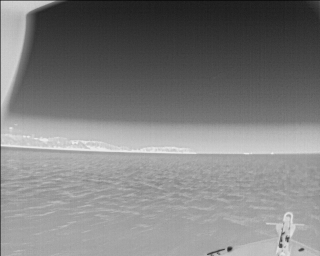

input image displayed


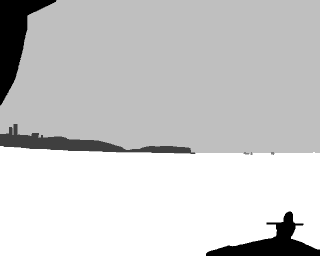

ground truth masked image displayed
raw values of prediction [[[0.08639523 0.09084696 0.33254918 ... 0.03744259 0.24382472 0.06323766]
  [0.18605764 0.08232329 0.1616648  ... 0.12596174 0.18131857 0.09502366]
  [0.176988   0.07863654 0.15570074 ... 0.13920926 0.18105243 0.09232275]
  ...
  [0.22563943 0.1710245  0.11749382 ... 0.14069438 0.14606261 0.07092372]
  [0.24049447 0.16729903 0.12156381 ... 0.13424797 0.14108768 0.07076597]
  [0.16455758 0.1374027  0.10095448 ... 0.13314897 0.08459645 0.09098028]]

 [[0.15488003 0.10554964 0.18623725 ... 0.1222138  0.11352003 0.16219424]
  [0.14044528 0.14236818 0.17505684 ... 0.14557783 0.11541412 0.14078853]
  [0.15121701 0.12709977 0.1627071  ... 0.13155165 0.12183578 0.15132001]
  ...
  [0.15972406 0.13980336 0.14515163 ... 0.1780244  0.10294811 0.13673094]
  [0.17254663 0.1344095  0.14742388 ... 0.16535999 0.10950517 0.13411376]
  [0.15820177 0.14347439 0.12152676 ... 0.13488597 0.10552848 0.12357471]]

 [[0.15974188 0.11632946 0.18810026

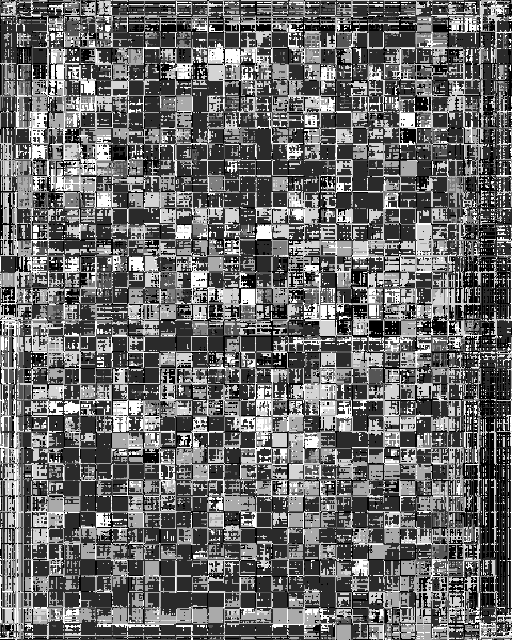

inference masked image displayed


In [14]:
# now display input, segmentation and prediction
def display_mask(i):
    """Quick utility to display a model's prediction."""
    print ("raw values of prediction",validation_preds[i])
    preds_final = np.argmax(validation_preds[i], axis = -1)
    print ("max value of predictions", preds_final)
    mask = np.expand_dims(preds_final, axis = -1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    #print ("width is {0}". format(img.size()))
    display(img)
    
# Display results for validation image #3
i = 2

# Display input image
display(Image(filename=input_img_paths[i]))
print ("input image displayed")

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(segmentation_img_paths[i]))
display(img)
print ("ground truth masked image displayed")

# Display mask predicted by our model
display_mask(i) 
print ("inference masked image displayed") 